## Unsupervised Outlier Detection

In [10]:
from __future__ import division
from __future__ import print_function

import warnings
from collections import defaultdict

import abc
import six

import pandas as pd
import numpy as np
from numpy import percentile
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils import deprecated
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.multiclass import check_classification_targets

In [159]:
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from scipy import stats
pd.options.display.max_rows = 365

## Test on each Dataset Seperetly 

### Price Dataset

In [222]:
price = pd.read_csv('btc_preprocessed.csv', index_col = 0)
X = price
X.columns

Index(['close', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'CCI',
       'ichimoku_leadSpanA', 'ichimoku_leadSpanB', 'MACD', 'MACD_diff',
       'MACD_signal', 'AwesomeOscillator', 'KAMA', 'RateofChange', 'RSI_7',
       'RSI_14', 'StochasticOscillator', 'stoch_signal', 'TrueStrenghtIndex',
       'UltimateOscilator', 'williamsR', 'Accum_Distrubution', 'ForceIndex',
       'AvgTrueRange', 'BollingerHighBand', 'BHB_indicator',
       'BollingerLowBand', 'BLB_indicator', 'BC_middleBand', 'BC_percBand',
       'BCB_width', 'sma_5', 'sma_10', 'sma_20', 'sma_30', 'sma_50', 'sma_100',
       'sma_200', 'ema_5', 'ema_10', 'ema_20', 'ema_30', 'ema_50', 'ema_100',
       'ema_200', 'vwma', 'hull_Moving', 'Mkt_Cap'],
      dtype='object')

In [223]:
random_state = np.random.RandomState(123)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

In [224]:
# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1 # WHY? * -1
    
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    
    # probability of outlier 
    probability = clf.predict_proba(X, method = 'linear')
    
    # predict rank
    predict_rank = clf._predict_rank(X)
    
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = X.copy()
    
    dfx[clf_name] = y_pred.tolist()
    #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
    #print('scores_pred: ', scores_pred)
    scores_pred_lst.append(scores_pred)
    df_outliers.append(dfx[clf_name]) 
    proba_lst.append(probability)
    predict_rank_lst.append(predict_rank)

OUTLIERS :  19 INLIERS :  346 Angle-based Outlier Detector (ABOD)
OUTLIERS :  19 INLIERS :  346 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  18 INLIERS :  347 Feature Bagging
OUTLIERS :  19 INLIERS :  346 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  19 INLIERS :  346 Isolation Forest
OUTLIERS :  15 INLIERS :  350 K Nearest Neighbors (KNN)
OUTLIERS :  16 INLIERS :  349 Average KNN


In [225]:
prices_df = df_outliers

## Outlier probability on Prices
Predict the probability of a sample being outlier. Two approaches are possible:
1. simply use Min-max conversion to linearly transform the outlier scores into the range of [0,1]. The model must be
fitted first.
2. use unifying scores, see :cite:`kriegel2011interpreting`.

In [226]:
outlier_proba = np.transpose(pd.DataFrame(probability)).T
outlier_proba.index = X.index
outlier_proba

,0,1
timestamp,,
2018-01-01,0.928306,0.071694
2018-01-02,0.420512,0.579488
2018-01-03,0.689075,0.310925
2018-01-04,0.634846,0.365154
2018-01-05,0.696192,0.303808
2018-01-06,0.640846,0.359154
2018-01-07,0.253689,0.746311
2018-01-08,0.463664,0.536336
2018-01-09,0.658381,0.341619


## Outliers in Dates (I am guessing rounded)

In [227]:
btc_outliers = np.transpose(pd.DataFrame(df_outliers))
btc_outliers

,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN
timestamp,,,,,,,
2018-01-01,1,0,0,0,1,0,0
2018-01-02,1,1,1,0,1,1,1
2018-01-03,1,1,1,0,1,1,1
2018-01-04,1,1,1,0,1,1,1
2018-01-05,1,1,1,0,1,1,1
2018-01-06,1,1,1,0,1,1,1
2018-01-07,1,1,1,0,1,1,1
2018-01-08,1,1,1,0,1,1,1
2018-01-09,1,1,1,0,1,1,1


## Predict Rank Scores
Predict the outlyingness rank of a sample by a fitted model. The method is for outlier detector score combination.

In [228]:
pred_rank_df = np.transpose(pd.DataFrame(predict_rank_lst))
pred_rank_df.columns = classifiers.keys()
pred_rank_df

,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN
0,350,325,331,326,353,334,336
1,365,364,364,308,360,359,362
2,352,363,362,291,356,354,352
3,356,360,360,297,357,355,354
4,353,362,362,324,362,354,352
5,356,361,360,304,364,356,354
6,363,359,359,305,363,361,362
7,360,355,358,238,359,360,357
8,350,351,356,126,352,355,354
9,350,353,357,232,355,356,354


### Intersection dates

In [229]:
# number of outliers identified per method 
outlier_dates = [] # store dates here 
for col in btc_outliers.columns:
    outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
    #df_outliers.timestamp.apply(lambda x: x.strftime('%Y-%m-%d')) # datetime to string 
    outlier_dates.append(outliers.index) # append the string/date

In [230]:
def intersection(lst1, lst2,lst3,lst4,lst5,lst6,lst7): 
    return list(set(lst1) & set(lst2)& set(lst3)& set(lst4)& set(lst5)& set(lst6)& set(lst7))

In [231]:
print('Nbr of common anomalies among all models: ',len(intersection(outlier_dates[0],outlier_dates[1],outlier_dates[2],
        outlier_dates[3],outlier_dates[4],outlier_dates[5],outlier_dates[6])))

Nbr of common anomalies among all models:  0


## Blockhain Test (need to add some feature engineering)
- note no feature engineering added to this dataset

In [232]:
block = pd.read_csv('blockchain18.csv', index_col = 0)
X = block

In [233]:
X.columns

Index(['active_addresses', 'average_transaction_value', 'block_height',
       'block_size', 'block_time', 'current_supply', 'difficulty', 'hashrate',
       'large_transaction_count', 'new_addresses', 'transaction_count',
       'transaction_count_all_time', 'unique_addresses_all_time',
       'zero_balance_addresses_all_time'],
      dtype='object')

In [234]:
# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1 # WHY? * -1
    
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    
    # probability of outlier 
    probability = clf.predict_proba(X, method = 'linear')
    
    # predict rank
    predict_rank = clf._predict_rank(X)
    
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = X.copy()
    
    dfx[clf_name] = y_pred.tolist()
    #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
    #print('scores_pred: ', scores_pred)
    scores_pred_lst.append(scores_pred)
    df_outliers.append(dfx[clf_name]) 
    proba_lst.append(probability)
    predict_rank_lst.append(predict_rank)

OUTLIERS :  20 INLIERS :  345 Angle-based Outlier Detector (ABOD)
OUTLIERS :  19 INLIERS :  346 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  16 INLIERS :  349 Feature Bagging
OUTLIERS :  19 INLIERS :  346 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  19 INLIERS :  346 Isolation Forest
OUTLIERS :  19 INLIERS :  346 K Nearest Neighbors (KNN)
OUTLIERS :  17 INLIERS :  348 Average KNN


In [235]:
block_df = df_outliers

## Outlier Probability on Blockchain

In [236]:
outlier_proba = np.transpose(pd.DataFrame(probability)).T
outlier_proba.index = X.index
outlier_proba

,0,1
timestamp,,
2018-01-01,0.956412,4.358809e-02
2018-01-02,0.999994,6.236374e-06
2018-01-03,0.999997,2.828076e-06
2018-01-04,0.999998,2.107649e-06
2018-01-05,0.999995,4.967356e-06
2018-01-06,0.999999,1.393838e-06
2018-01-07,1.000000,4.077923e-07
2018-01-08,1.000000,0.000000e+00
2018-01-09,1.000000,1.591324e-07


## Outlier Date Counts

In [237]:
btc_outliers = np.transpose(pd.DataFrame(df_outliers))
btc_outliers

,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN
timestamp,,,,,,,
2018-01-01,1,1,0,0,1,0,0
2018-01-02,0,1,0,0,1,0,0
2018-01-03,0,1,0,0,1,0,0
2018-01-04,0,1,0,0,1,0,0
2018-01-05,0,1,0,0,1,0,0
2018-01-06,0,1,0,0,1,0,0
2018-01-07,0,1,0,0,1,0,0
2018-01-08,0,1,0,0,1,0,0
2018-01-09,0,1,0,0,1,0,0


## Predict Rank Scores

In [238]:
pred_rank_df = np.transpose(pd.DataFrame(predict_rank_lst))
pred_rank_df.columns = classifiers.keys()
pred_rank_df

,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN
0,349,364,303,293,359,342,341
1,272,363,300,307,361,195,117
2,159,362,299,294,362,79,23
3,105,361,297,310,364,56,10
4,259,360,295,341,363,56,80
5,45,359,295,345,360,56,5
6,28,358,295,295,357,47,2
7,5,357,295,307,353,1,0
8,3,356,295,195,356,56,1
9,22,355,295,194,355,54,7


## Intersection Dates 

In [239]:
# number of outliers identified per method 
outlier_dates = [] # store dates here 
for col in btc_outliers.columns:
    outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
    #df_outliers.timestamp.apply(lambda x: x.strftime('%Y-%m-%d')) # datetime to string 
    outlier_dates.append(outliers.index) # append the string/date

In [240]:
print('Nbr of common anomalies among all models: ',len(intersection(outlier_dates[0],outlier_dates[1],outlier_dates[2],
        outlier_dates[3],outlier_dates[4],outlier_dates[5],outlier_dates[6])))

Nbr of common anomalies among all models:  0


# Social Dataset Test (need to adress 0's I guess)

In [241]:
social = pd.read_csv("social18.csv", index_col = 0)
X = social

In [242]:
X.columns

Index(['comments', 'posts', 'followers', 'points', 'overview_page_views',
       'analysis_page_views', 'markets_page_views', 'charts_page_views',
       'trades_page_views', 'forum_page_views', 'influence_page_views',
       'total_page_views', 'fb_likes', 'fb_talking_about', 'twitter_followers',
       'twitter_following', 'twitter_lists', 'twitter_favourites',
       'twitter_statuses', 'reddit_subscribers', 'reddit_active_users',
       'reddit_posts_per_hour', 'reddit_posts_per_day',
       'reddit_comments_per_hour', 'reddit_comments_per_day',
       'code_repo_stars', 'code_repo_forks', 'code_repo_subscribers',
       'code_repo_open_pull_issues', 'code_repo_closed_pull_issues',
       'code_repo_open_issues', 'code_repo_closed_issues',
       'code_repo_contributors'],
      dtype='object')

In [243]:
# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1 # WHY? * -1
    
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    
    # probability of outlier 
    probability = clf.predict_proba(X, method = 'linear')
    
    # predict rank
    predict_rank = clf._predict_rank(X)
    
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = X.copy()
    
    dfx[clf_name] = y_pred.tolist()
    #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
    #print('scores_pred: ', scores_pred)
    scores_pred_lst.append(scores_pred)
    df_outliers.append(dfx[clf_name]) 
    proba_lst.append(probability)
    predict_rank_lst.append(predict_rank)

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

OUTLIERS :  0 INLIERS :  365 Angle-based Outlier Detector (ABOD)
OUTLIERS :  19 INLIERS :  346 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  15 INLIERS :  350 Feature Bagging
OUTLIERS :  19 INLIERS :  346 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  19 INLIERS :  346 Isolation Forest
OUTLIERS :  11 INLIERS :  354 K Nearest Neighbors (KNN)
OUTLIERS :  5 INLIERS :  360 Average KNN


In [244]:
social_df = df_outliers

## Probability Scores

In [245]:
outlier_proba = np.transpose(pd.DataFrame(probability)).T
outlier_proba.index = X.index
outlier_proba

,0,1
timestamp,,
2018-01-01,0.606971,0.393029
2018-01-02,0.745848,0.254152
2018-01-03,0.787702,0.212298
2018-01-04,0.778137,0.221863
2018-01-05,0.760205,0.239795
2018-01-06,0.758502,0.241498
2018-01-07,0.778410,0.221590
2018-01-08,0.769260,0.230740
2018-01-09,0.757864,0.242136


## Outlier Date Counts

In [246]:
btc_outliers = np.transpose(pd.DataFrame(df_outliers))
btc_outliers

,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN
timestamp,,,,,,,
2018-01-01,0,0,1,1,1,1,0
2018-01-02,0,0,1,1,1,0,0
2018-01-03,0,0,1,1,1,0,0
2018-01-04,0,0,1,0,1,0,0
2018-01-05,0,0,0,0,1,0,0
2018-01-06,0,0,0,1,1,0,0
2018-01-07,0,0,0,1,1,0,0
2018-01-08,0,0,0,1,1,0,0
2018-01-09,0,0,0,1,1,0,0


## Predict Rank Scores

In [247]:
pred_rank_df = np.transpose(pd.DataFrame(predict_rank_lst))
pred_rank_df.columns = classifiers.keys()
pred_rank_df

,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN
0,352,342,360,361,364,352,342
1,318,340,358,360,363,336,288
2,243,337,355,359,356,305,269
3,247,335,353,339,361,319,275
4,325,326,346,344,360,275,282
5,308,319,342,364,355,321,283
6,311,305,338,357,358,287,275
7,316,280,334,358,354,281,277
8,318,256,324,363,353,304,283
9,325,224,318,362,352,294,284


## Intersection Dates

In [248]:
# number of outliers identified per method 
outlier_dates = [] # store dates here 
for col in btc_outliers.columns:
    outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
    #df_outliers.timestamp.apply(lambda x: x.strftime('%Y-%m-%d')) # datetime to string 
    outlier_dates.append(outliers.index) # append the string/date

In [249]:
print('Nbr of common anomalies among all models: ',len(intersection(outlier_dates[0],outlier_dates[1],outlier_dates[2],
        outlier_dates[3],outlier_dates[4],outlier_dates[5],outlier_dates[6])))

Nbr of common anomalies among all models:  0


# Anomaly Detection on all 3 datasets together

In [250]:
merged_df = pd.concat([price,block,social], axis = 1)
X = merged_df
merged_df.shape

(365, 96)

In [251]:
# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1 # WHY? * -1
    
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    
    # probability of outlier 
    probability = clf.predict_proba(X, method = 'linear')
    
    # predict rank
    predict_rank = clf._predict_rank(X)
    
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = X.copy()
    
    dfx[clf_name] = y_pred.tolist()
    #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
    #print('scores_pred: ', scores_pred)
    scores_pred_lst.append(scores_pred)
    df_outliers.append(dfx[clf_name]) 
    proba_lst.append(probability)
    predict_rank_lst.append(predict_rank)

OUTLIERS :  18 INLIERS :  347 Angle-based Outlier Detector (ABOD)
OUTLIERS :  19 INLIERS :  346 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  17 INLIERS :  348 Feature Bagging
OUTLIERS :  19 INLIERS :  346 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  19 INLIERS :  346 Isolation Forest
OUTLIERS :  13 INLIERS :  352 K Nearest Neighbors (KNN)
OUTLIERS :  9 INLIERS :  356 Average KNN


In [252]:
three = df_outliers

## Probability

In [253]:
outlier_proba = np.transpose(pd.DataFrame(probability)).T
outlier_proba.index = X.index
outlier_proba

,0,1
timestamp,,
2018-01-01,0.724712,0.275288
2018-01-02,0.420596,0.579404
2018-01-03,0.689214,0.310786
2018-01-04,0.634974,0.365026
2018-01-05,0.696332,0.303668
2018-01-06,0.640975,0.359025
2018-01-07,0.253740,0.746260
2018-01-08,0.402565,0.597435
2018-01-09,0.564125,0.435875


## Outlier Date Counts

In [254]:
btc_outliers = np.transpose(pd.DataFrame(df_outliers))
btc_outliers

,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN
timestamp,,,,,,,
2018-01-01,0,1,0,0,1,1,0
2018-01-02,1,1,1,0,1,1,1
2018-01-03,0,1,1,0,1,1,0
2018-01-04,0,1,0,0,1,1,1
2018-01-05,0,1,1,0,1,0,0
2018-01-06,0,1,0,0,1,1,1
2018-01-07,1,1,0,0,1,1,1
2018-01-08,1,1,0,0,1,1,1
2018-01-09,0,1,0,0,1,1,1


## Predict Rank Scores

In [255]:
pred_rank_df = np.transpose(pd.DataFrame(predict_rank_lst))
pred_rank_df.columns = classifiers.keys()
pred_rank_df.index = merged_df.index
pred_rank_df

,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN
timestamp,,,,,,,
2018-01-01,338,350,317,332,358,346,340
2018-01-02,362,364,363,326,363,357,358
2018-01-03,334,363,348,323,359,350,342
2018-01-04,339,360,346,320,360,355,350
2018-01-05,334,362,349,331,364,344,341
2018-01-06,340,361,346,327,362,355,347
2018-01-07,359,359,343,324,361,360,362
2018-01-08,353,358,329,314,357,361,358
2018-01-09,324,356,327,253,355,355,353


# Intersection Between Merge and different datasets

In [256]:
# number of outliers identified per method 
outlier_dates = [] # store dates here 
for col in btc_outliers.columns:
    outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
    #df_outliers.timestamp.apply(lambda x: x.strftime('%Y-%m-%d')) # datetime to string 
    outlier_dates.append(outliers.index) # append the string/date

In [257]:
print('Nbr of common anomalies among all models: ',len(intersection(outlier_dates[0],outlier_dates[1],outlier_dates[2],
        outlier_dates[3],outlier_dates[4],outlier_dates[5],outlier_dates[6])))

Nbr of common anomalies among all models:  0


## CBLOF intersection dates across tests (arbitrary model check)

In [ ]:
prices_df
block_df
social_df
three

In [296]:
[x for x in three[3] if x in prices_df[3]]

[]

In [276]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [281]:
# prices and blockchain
intersection(prices_df[1], block_df[1])

[0, 1]

In [282]:
intersection(prices_df[1], social_df[1])

[0, 1]

In [84]:
dates_knn = list(btc_outliers[btc_outliers['K Nearest Neighbors (KNN)']==1].index)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

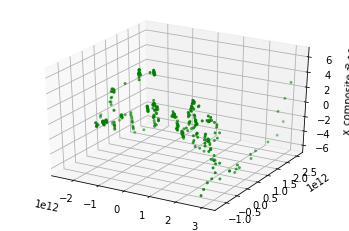

In [297]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[dates_knn,0],X_reduce[dates_knn,1], X_reduce[dates_knn,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [41]:
from pyod.models.knn import KNN

clf_name = 'KNN'
clf = KNN(contamination=0.05)
clf.fit(X.values)

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [59]:
# predict raw anomaly score 
# np.set_printoptions(precision=None)

#clf.decision_scores_

scores_pred = clf.decision_function(X) 
print(scores_pred.shape)

(365,)


In [65]:
# get the prediction on the test data
y_pred = clf.predict(X)  # outlier labels (0 or 1)
print(y_pred.shape)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
# threshold value to consider a datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred,100 * 0.05)
threshold

(365,)
OUTLIERS :  15 INLIERS :  350 KNN


1434902168.429861